In [1]:
import gym4real.envs.trading
import numpy as np
import matplotlib.pyplot as plt
from gym4real.envs.trading.utils import parameter_generator
import gymnasium as gym
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from sbx import PPO
from stable_baselines3 import DQN
from gym4real.algorithms.trading.utils import evaluate_agent_with_baselines, evaluate_multiple_agents_with_baselines
import random
import os

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL


In [11]:
args = {
        'exp_name': 'trading/ppo',
        'n_episodes': 30,
        'n_envs': 6,
        'policy_kwargs': dict(net_arch=[512, 512]),
        'verbose': False,
        'gamma': 0.90,
        'learning_rate': 0.0001,
        'log_rate': 10,
        'batch_size': 236,
        'n_steps':  118*6,
        'ent_coeff': 0.,
        'save_model_as': 'ppo_sr_10_eps',
        'seeds': [32517, 84029, 10473, 67288, 91352, 47605]
    }

In [12]:
params_train = parameter_generator(world_options='gym4real/envs/trading/world_train.yaml')
params_validation = parameter_generator(world_options='gym4real/envs/trading/world_validation.yaml')
params_test = parameter_generator(world_options='gym4real/envs/trading/world_test.yaml')


Training or Loading PPO agent

In [13]:
train_ppo = False

if train_ppo is True: #Train PPO
    for seed in args['seeds']:
        print("######## PPO is running... ########")
        
        train_env = make_vec_env("gym4real/TradingEnv-v0", n_envs=args['n_envs'], env_kwargs={'settings':params_train, 'seed': seed})
        eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
        
        logdir = "./gym4real/algorithms/trading/logs/" + args['exp_name']
        os.makedirs(logdir, exist_ok=True)
        
        eval_callback = EvalCallback(eval_env,
                                     best_model_save_path="./logs/{}/models/eval/".format(args['exp_name']+f"_seed_{seed}"),
                                     log_path="./logs/",
                                     eval_freq= (1 * train_env.env_method("get_trading_day_num")[0] * 118) / 2,
                                     n_eval_episodes=eval_env.unwrapped.get_trading_day_num(),
                                     deterministic=True,
                                     render=False)


        callbacks = [eval_callback]

        model = PPO("MlpPolicy",
                    env=train_env,
                    verbose=args['verbose'],
                    gamma=args['gamma'],
                    policy_kwargs=args['policy_kwargs'],
                    n_steps=args['n_steps'],
                    tensorboard_log="./gym4real/algorithms/trading/logs/tensorboard/trading/ppo/{}".format(args['exp_name']+f"_seed_{seed}"),
                    learning_rate=args['learning_rate'],
                    batch_size = args['batch_size'],
                    seed=seed
                    )

        model.learn(total_timesteps= args['n_episodes'] * train_env.env_method("get_trading_day_num")[0] * 598,
                    progress_bar=True,
                    log_interval=args['log_rate'],
                    tb_log_name="ppo_{}".format(args['exp_name']+f"_seed_{seed}"),
                    callback=callbacks,
                    reset_num_timesteps=True,)

        model.save("./logs/{}/models/{}".format(args['exp_name']+f"_seed_{seed}", args['save_model_as']))
        print("######## TRAINING is Done ########") 
else:
    train_env = make_vec_env("gym4real/TradingEnv-v0",  n_envs=args['n_envs'], env_kwargs={'settings':params_train} )
    eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
#Load Best PPO models
models_ppo = []
for seed in args['seeds']:
    model_folder = "./gym4real/algorithms/trading/logs/{}/models/".format(args['exp_name'] + f"_seed_{seed}")
    model = PPO.load(os.path.join(model_folder, "eval", "best_model"))
    models_ppo.append(model)
    

/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the pos

Train or Load DQN

In [15]:
args = {
        'exp_name': 'trading/dqn',
        'n_episodes': 10,
        'n_envs': 6,
        'policy_kwargs': dict(
            net_arch=[512, 512]
        ),
        'verbose': False,
        'gamma': 0.90,
        'learning_rate': 0.0001,
        'log_rate': 10,
        'batch_size': 64,
        'buffer_size': 1000000,
        'learning_starts': 100,
        'exploration_fraction': 0.2,
        'exploration_final_eps': 0.05,
        'tau': 1.0,
        'train_freq': 4,
        'save_model_as': 'dqn_trading_10eps',
        'seeds': [32517, 84029, 10473, 67288, 91352, 47605]
    }

In [16]:
train_dqn = False
if train_dqn is True:
    for seed in args['seeds']:
        print("######## DQN is running... ########")
        logdir = "./logs/" + args['exp_name']
        os.makedirs(logdir, exist_ok=True)
        train_env = make_vec_env("gym4real/TradingEnv-v0", n_envs=args['n_envs'],env_kwargs={'settings': params_train, 'seed':seed})
        eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings': params_validation, 'scaler': train_env.env_method('get_scaler')[0], 'seed': seed})

        eval_callback = EvalCallback(eval_env,
                                     best_model_save_path="./logs/{}/models/eval/".format(args['exp_name']+f"_seed_{seed}"),
                                     log_path="./logs/",
                                     eval_freq=(1 * train_env.env_method("get_trading_day_num")[0] * 118) / 2,
                                     n_eval_episodes=eval_env.unwrapped.get_trading_day_num(),
                                     deterministic=True,
                                     render=False)

        callbacks = [eval_callback]
        model = DQN("MlpPolicy",
                    env=train_env,
                    verbose=args['verbose'],
                    gamma=args['gamma'],
                    policy_kwargs=args['policy_kwargs'],
                    tensorboard_log="./logs/tensorboard/trading/dqn/{}".format(args['exp_name']+f"_seed_{seed}"),
                    stats_window_size=100,
                    learning_rate=args['learning_rate'],
                    batch_size=args['batch_size'],
                    buffer_size=args['buffer_size'],
                    learning_starts=args['learning_starts'],
                    exploration_fraction=args['exploration_fraction'],
                    exploration_final_eps=args['exploration_final_eps'],
                    tau=args['tau'],
                    train_freq=args['train_freq'],
                    seed=seed
                    )

        model.learn(total_timesteps=args['n_envs'] * args['n_episodes'] * train_env.env_method("get_trading_day_num")[0] * 598,
                    progress_bar=True,
                    log_interval=args['log_rate'],
                    tb_log_name="dqn_{}".format(args['exp_name']),
                    callback=callbacks,
                    reset_num_timesteps=True, )

        model.save("./logs/{}/models/{}".format(args['exp_name']+f"_seed_{seed}", args['save_model_as']))
        print("######## TRAINING is Done ########")
else:
    train_env = make_vec_env("gym4real/TradingEnv-v0",  n_envs=args['n_envs'], env_kwargs={'settings':params_train} )
    eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
#Load Best PPO models
models_dqn = []
for seed in args['seeds']:
    model_folder = "./gym4real/algorithms/trading/logs/{}/models/".format(args['exp_name'] + f"_seed_{seed}")
    model = DQN.load(os.path.join(model_folder, "eval", "best_model"))
    models_dqn.append(model)
    

/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniforge3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the pos

In [17]:
models = {
    "PPO": models_ppo,
    "DQN": models_dqn
}

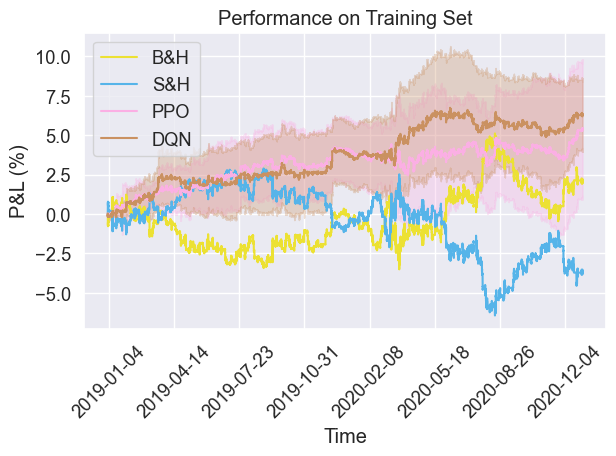

In [35]:
params_train['sequential'] = True
evaluate_multiple_agents_with_baselines(models, params_train, None, 'Training')

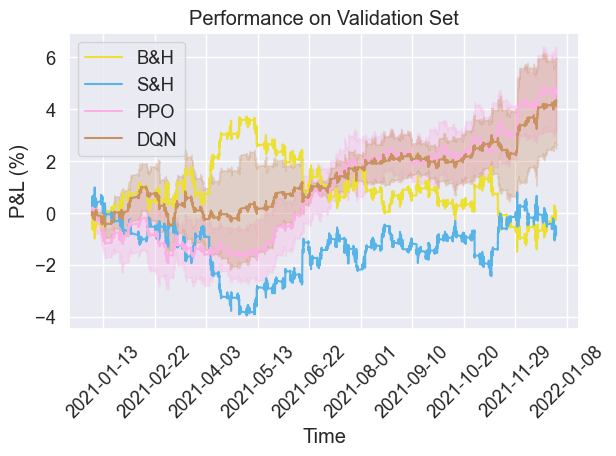

In [36]:
evaluate_multiple_agents_with_baselines(models, params_validation, train_env.env_method("get_scaler")[0], 'Validation')

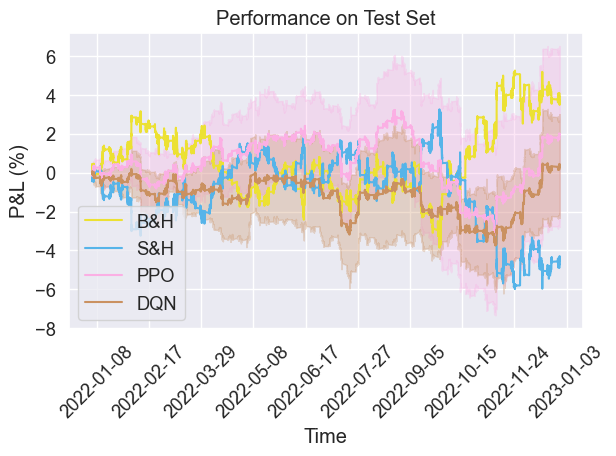

In [37]:
evaluate_multiple_agents_with_baselines(models, params_test, train_env.env_method("get_scaler")[0], 'Test')